In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
dataframe = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
print(dataframe.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [26]:
print("Missing Values:")

X = dataframe.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = dataframe['isFraud']


numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns


vif = pd.DataFrame()
vif['features'] = numeric_cols
vif['VIF'] = [variance_inflation_factor(X[numeric_cols].values, i)

for i in range(X[numeric_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)

highly_correlated_features = vif[vif['VIF'] > 5]['features'].tolist()

print(dataframe.isnull().sum())

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [27]:
X = dataframe.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = dataframe['isFraud']


numerical_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns


vif = pd.DataFrame()
vif['features'] = numeric_cols
vif['VIF'] = [variance_inflation_factor(X[numeric_cols].values, i) for i in range(X[numeric_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)

highly_correlated_features = vif[vif['VIF'] > 5]['features'].tolist()

In [28]:
z_scores = np.abs(stats.zscore(dataframe[numerical_cols]))
print("\nOutliers:")
print(np.where(z_scores > 3))


Outliers:
(array([     84,      88,      89, ..., 6362617, 6362618, 6362619]), array([5, 5, 5, ..., 1, 0, 0]))


In [29]:
dataframe = dataframe[(z_scores < 3).all(axis=1)]

In [30]:
vif = pd.DataFrame(columns=['VIF', 'features'])
vif_data = dataframe[numerical_cols]

for i in range(vif_data.shape[1]):
    if vif_data.iloc[:, i].var() > 0:
        vif.loc[i] = [variance_inflation_factor(vif_data.values, i), vif_data.columns[i]]
    else:
        vif.loc[i] = [0, vif_data.columns[i]]

print("\nVIF Analysis:")
print(vif.sort_values('VIF', ascending=False))


VIF Analysis:
          VIF        features
3  376.181060  newbalanceOrig
2  364.716035   oldbalanceOrg
5  136.179149  newbalanceDest
4  124.387283  oldbalanceDest
1    3.601899          amount
0    1.427661            step


In [31]:
highly_correlated_features = vif[vif['VIF'] > 5]['features'].tolist()
dataframe = dataframe.drop(highly_correlated_features, axis=1)

In [33]:
if set(numerical_cols).issubset(set(dataframe.columns)):
    if dataframe[numerical_cols].shape[0] > 0:
        pca = PCA(n_components=0.95)
        pca_data = pca.fit_transform(dataframe[numerical_cols])
        dataframe_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
    else:
        dataframe_pca = pd.DataFrame()
        print("The dataframe is empty.")
else:
    dataframe_pca = pd.DataFrame()
    print("The columns do not exist in the dataframe.")

dataframe_cleaned = pd.concat([dataframe[categorical_cols], dataframe_pca, dataframe[['isFraud', 'isFlaggedFraud']]], axis=1)
print("\nCleaned Dataset:")
print(dataframe_cleaned.head())

The columns do not exist in the dataframe.

Cleaned Dataset:
       type     nameOrig     nameDest  isFraud  isFlaggedFraud
0   PAYMENT  C1231006815  M1979787155        0               0
1   PAYMENT  C1666544295  M2044282225        0               0
2  TRANSFER  C1305486145   C553264065        1               0
3  CASH_OUT   C840083671    C38997010        1               0
4   PAYMENT  C2048537720  M1230701703        0               0


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4816100
           1       1.00      1.00      1.00      4661

    accuracy                           1.00   4820761
   macro avg       1.00      1.00      1.00   4820761
weighted avg       1.00      1.00      1.00   4820761

Confusion Matrix:
[[4816100       0]
 [      0    4661]]


Text(50.722222222222214, 0.5, 'Actual')

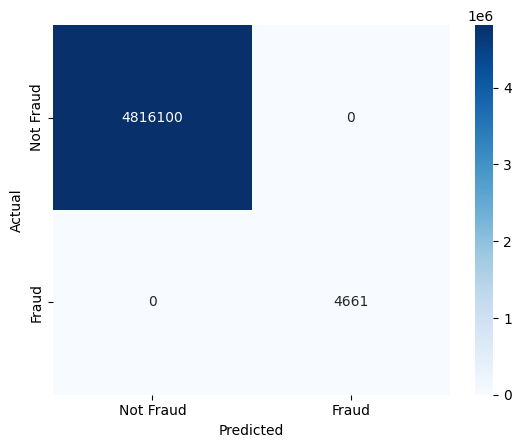

In [34]:
X = dataframe.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = dataframe['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dtc = DecisionTreeClassifier(random_state=42)

le = LabelEncoder()


categorical_cols = X_train.select_dtypes(include=['object']).columns


for col in categorical_cols:
    X_train[col] = le.fit_transform(X_train[col])


dtc.fit(X_train, y_train)


y_train = dtc.predict(X_train)


accuracy = accuracy_score(y_train, y_train)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_train, y_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train))



cm = confusion_matrix(y_train, y_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

Key factors predicting fraudulent customers:
    Feature  Importance
0      step    0.340918
2    amount    0.275852
3  nameOrig    0.197023
4  nameDest    0.179225
1      type    0.006982


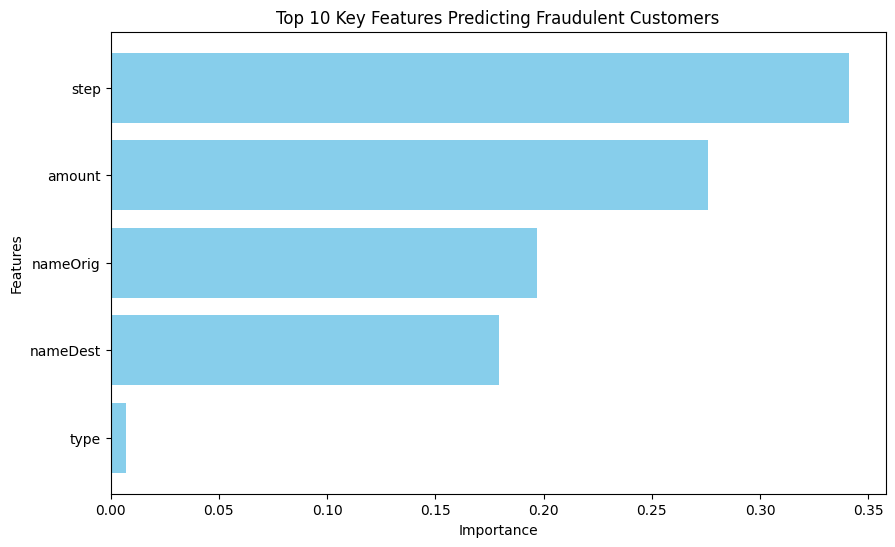

In [35]:
feature_importances = dtc.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print("Key factors predicting fraudulent customers:")
print(feature_importance_df.head(10))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Key Features Predicting Fraudulent Customers')
plt.gca().invert_yaxis()
plt.show()
